### **HYBRID FILTERING** ###

##### ***INFORMATION*** ######
- Prediction = α × CF_Prediction + (1 - α) × CBF_Prediction
We’ll set α = 0.5 to give equal weight

In [10]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt
from fastai.vision.all import untar_data, URLs

In [2]:
# Load Data
path = untar_data(URLs.ML_100k)
ratings = pd.read_csv(path/'u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

# Load movies and genre
movies = pd.read_csv(
    path/'u.item', sep='|', encoding='latin-1', header=None,
    names=['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL'] + [f'genre_{i}' for i in range(19)]
)
movie_genres = movies[['item_id'] + [f'genre_{i}' for i in range(19)]]

# Merge ratings and movie content
ratings_content = pd.merge(ratings, movie_genres, on='item_id')


In [3]:
# Train-test split
train_df, test_df = train_test_split(ratings_content, test_size=0.2, random_state=42)

# Collaborative
# User-Item Matrix for CF
user_item_matrix = train_df.pivot(index='user_id', columns='item_id', values='rating')

# Fill NaN with 0 for similarity calc
user_similarity = cosine_similarity(user_item_matrix.fillna(0))
user_sim_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

# Content-Based Filtering with User Profiles
user_profiles = {}

for user_id in train_df['user_id'].unique():
    user_data = train_df[train_df['user_id'] == user_id]
    genre_matrix = user_data[[f'genre_{i}' for i in range(19)]].values
    ratings_vector = user_data['rating'].values.reshape(-1, 1)
    profile = np.sum(genre_matrix * ratings_vector, axis=0)
    norm = np.linalg.norm(profile)
    user_profiles[user_id] = profile / norm if norm > 0 else profile

# Normalize genre vectors
genre_vectors = movie_genres.set_index('item_id')

for col in genre_vectors.columns:
    genre_vectors[col] = genre_vectors[col].astype(float)

genre_vectors_norm = genre_vectors.apply(lambda x: x / np.linalg.norm(x) if np.linalg.norm(x) > 0 else x, axis=1)

# Means
global_mean = train_df['rating'].mean()
user_avg = train_df.groupby('user_id')['rating'].mean().to_dict()
item_avg = train_df.groupby('item_id')['rating'].mean().to_dict()


In [4]:
# Predict rating functions

# Collaborative Filtering Prediction
def predict_cf(user_id, item_id, k=10):
    if item_id not in user_item_matrix.columns or user_id not in user_item_matrix.index:
        return user_avg.get(user_id, global_mean)

    sims = user_sim_df[user_id]
    item_ratings = user_item_matrix[item_id]

    valid_users = item_ratings[item_ratings.notna()].index
    sims = sims[valid_users]
    item_ratings = item_ratings[valid_users]

    top_k = sims.sort_values(ascending=False)[:k]
    top_ratings = item_ratings[top_k.index]

    if top_k.sum() == 0:
        return user_avg.get(user_id, global_mean)

    return np.dot(top_k, top_ratings) / np.sum(np.abs(top_k))

# Content-Based Filtering Prediction
def predict_cbf(user_id, item_id):
    if user_id in user_profiles and item_id in genre_vectors_norm.index:
        user_vec = user_profiles[user_id]
        item_vec = genre_vectors_norm.loc[item_id].values
        sim = np.dot(user_vec, item_vec)
        return np.clip(sim * 5, 1, 5)
    else:
        return item_avg.get(item_id, global_mean)

# Hybrid Prediction with alpha = 0.5
def predict_hybrid(user_id, item_id, alpha=0.5):
    cf_rating = predict_cf(user_id, item_id)
    cbf_rating = predict_cbf(user_id, item_id)
    return alpha * cf_rating + (1 - alpha) * cbf_rating


In [5]:
# Evaluate on test set
true_ratings = []
pred_ratings = []

for _, row in test_df.iterrows():
    uid, iid, true = row['user_id'], row['item_id'], row['rating']
    pred = predict_hybrid(uid, iid, alpha=0.5)
    true_ratings.append(true)
    pred_ratings.append(pred)

# Metrics
mae = mean_absolute_error(true_ratings, pred_ratings)
rmse = sqrt(mean_squared_error(true_ratings, pred_ratings))

print("Hybrid Recommendation System (alpha=0.5)")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

Hybrid Recommendation System (alpha=0.5)
MAE: 0.9997
RMSE: 1.2099


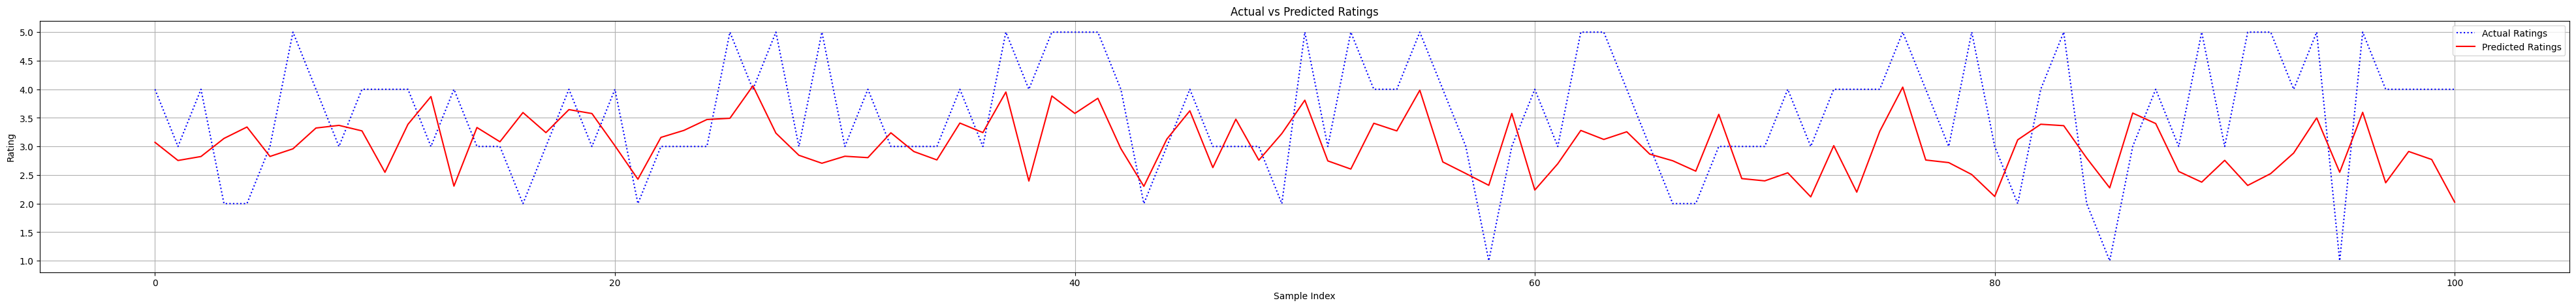

In [12]:
# Analyze Graphically

plt.figure(figsize=(50, 5))
plt.plot(true_ratings[0:101], label='Actual Ratings', linestyle='dotted', color='blue')
plt.plot(pred_ratings[0:101], label='Predicted Ratings' , linestyle='solid', color='red')
plt.title('Actual vs Predicted Ratings')
plt.xlabel('Sample Index')
plt.ylabel('Rating')
plt.legend()
plt.grid(True)
plt.show()